In [1]:
"""
Make the imports of python packages needed
"""
import pandas as pd
import numpy as np
from pprint import pprint
#Import the dataset and define the feature as well as the target datasets / columns#
dataset = pd.read_csv('zoo.csv',
                      names=['animal_name','hair','feathers','eggs','milk',
                                                   'airbone','aquatic','predator','toothed','backbone',
                                                  'breathes','venomous','fins','legs','tail','domestic','catsize','class',])
#Import all columns omitting the fist which consists the names of the animals
#We drop the animal names since this is not a good feature to split the data on
dataset=dataset.drop('animal_name',axis=1)

In [2]:
dataset.head()

,hair,feathers,eggs,milk,airbone,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [10]:
def entropy(target_col):
    """
    Calculate the entropy of a dataset.
    The only parameter of this function is the target_col parameter which specifies the target column
    """
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy

In [11]:
def InfoGain(data,split_attribute_name,target_name="class"):
    """
    Calculate the information gain of a dataset. This function takes three parameters:
    1. data = The dataset for whose feature the IG should be calculated
    2. split_attribute_name = the name of the feature for which the information gain should be calculated
    3. target_name = the name of the target feature. The default for this example is "class"
    """    
    #Calculate the entropy of the total dataset
    total_entropy = entropy(data[target_name])
    
    ##Calculate the entropy of the dataset
    
    #Calculate the values and the corresponding counts for the split attribute 
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)
    
    #Calculate the weighted entropy
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()
                                                                  [target_name]) for i in range(len(vals))])
    
    #Calculate the information gain
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain

In [12]:
def ID3(data,originaldata,features,target_attribute_name="class",parent_node_class = None):
    """
    ID3 Algorithm: This function takes five paramters:
    1. data = the data for which the ID3 algorithm should be run --> In the first run this equals the total dataset
 
    2. originaldata = This is the original dataset needed to calculate the mode target feature value of the original dataset
    in the case the dataset delivered by the first parameter is empty
    3. features = the feature space of the dataset . This is needed for the recursive call since during the tree growing process
    we have to remove features from our dataset --> Splitting at each node
    4. target_attribute_name = the name of the target attribute
    5. parent_node_class = This is the value or class of the mode target feature value of the parent node for a specific node. This is 
    also needed for the recursive call since if the splitting leads to a situation that there are no more features left in the feature
    space, we want to return the mode target feature value of the direct parent node.
    """   
    #Define the stopping criteria --> If one of this is satisfied, we want to return a leaf node#
    
    #If all target_values have the same value, return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
    #If the dataset is empty, return the mode target feature value in the original dataset
    elif len(data)==0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],return_counts=True)[1])]
    
    #If the feature space is empty, return the mode target feature value of the direct parent node --> Note that
    #the direct parent node is that node which has called the current run of the ID3 algorithm and hence
    #the mode target feature value is stored in the parent_node_class variable.
    
    elif len(features) ==0:
        return parent_node_class
    
    #If none of the above holds true, grow the tree!
    
    else:
        #Set the default value for this node --> The mode target feature value of the current node
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]
        
        #Select the feature which best splits the dataset
        item_values = [InfoGain(data,feature,target_attribute_name) for feature in features] #Return the information gain values for the features in the dataset
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        
        #Create the tree structure. The root gets the name of the feature (best_feature) with the maximum information
        #gain in the first run
        tree = {best_feature:{}}
        
        
        #Remove the feature with the best inforamtion gain from the feature space
        features = [i for i in features if i != best_feature]
        
        #Grow a branch under the root node for each possible value of the root node feature
        
        for value in np.unique(data[best_feature]):
            value = value
            #Split the dataset along the value of the feature with the largest information gain and therewith create sub_datasets
            sub_data = data.where(data[best_feature] == value).dropna()
            
            #Call the ID3 algorithm for each of those sub_datasets with the new parameters --> Here the recursion comes in!
            subtree = ID3(sub_data,dataset,features,target_attribute_name,parent_node_class)
            
            #Add the sub tree, grown from the sub_dataset to the tree under the root node
            tree[best_feature][value] = subtree
            
        return(tree)    

In [13]:
def predict(query,tree,default = 1):
    """
    Prediction of a new/unseen query instance. This takes two parameters:
    
    SUMMARIZED: If we have a query instance consisting of values for features, we take this features and check if the 
    name of the root node is equal to one of the query features.
    If this is true, we run down the root node outgoing branch whose value equals the value of query feature == the root node.
    If we find at the end of this branch a leaf node (not a dict object) we return this value (this is our prediction).
    If we instead find another node (== sub_tree == dict objct) we search in our query for the feature which equals the value 
    of that node. Next we look up the value of our query feature and run down the branch whose value is equal to the 
    query[key] == query feature value. And as you can see this is exactly the recursion we talked about
    with the important fact that for each node we run down the tree, we check only the nodes and branches which are 
    below this node and do not run the whole tree beginning at the root node 
    --> This is why we re-call the classification function with 'result'
    """
    
    
    #1.
    for key in list(query.keys()):
        if key in list(tree.keys()):
            #2.
            try:
                result = tree[key][query[key]] 
            except:
                return default
  
            #3.
            result = tree[key][query[key]]
            #4.
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result

In [21]:
def train_test_split(dataset):
    training_data = dataset.iloc[:80].reset_index(drop=True)#We drop the index respectively relabel the index
    #starting form 0, because we do not want to run into errors regarding the row labels / indexes
    testing_data = dataset.iloc[80:].reset_index(drop=True)
    return training_data,testing_data
training_data = train_test_split(dataset)[0]
testing_data = train_test_split(dataset)[1] 
def test(data,tree):
    #Create new query instances by simply removing the target feature column from the original dataset and 
    #convert it to a dictionary
    queries = data.iloc[:,:-1].to_dict(orient = "records")
    #Create a empty DataFrame in whose columns the prediction of the tree are stored
    predicted = pd.DataFrame(columns=["predicted"]) 
    
    #Calculate the prediction accuracy
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predict(queries[i],tree,1.0) 
    print('The prediction accuracy is: ',(np.sum(predicted["predicted"] == data["class"])/len(data))*100,'%')

In [22]:
"""
Train the tree, Print the tree and predict the accuracy
"""
tree = ID3(training_data,training_data,training_data.columns[:-1])
pprint(tree)
test(testing_data,tree)

{'legs': {0: {'fins': {0.0: {'toothed': {0.0: 7.0, 1.0: 3.0}},
                       1.0: {'eggs': {0.0: 1.0, 1.0: 4.0}}}},
          2: {'hair': {0.0: 2.0, 1.0: 1.0}},
          4: {'hair': {0.0: {'toothed': {0.0: 7.0, 1.0: 5.0}}, 1.0: 1.0}},
          6: {'aquatic': {0.0: 6.0, 1.0: 7.0}},
          8: 7.0}}
The prediction accuracy is:  85.71428571428571 %


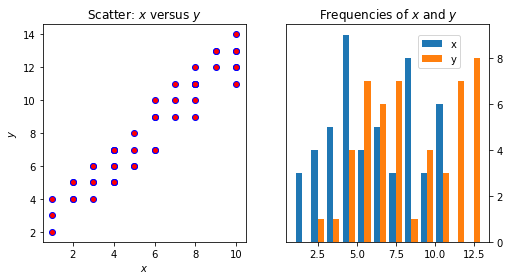

In [22]:
x = np.random.randint(low=1, high=11, size=50)
y = x + np.random.randint(1, 5, size=x.size)
data = np.column_stack((x, y))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                              figsize=(8, 4))

ax1.scatter(x=x, y=y, marker='o', c='r', edgecolor='b')
ax1.set_title('Scatter: $x$ versus $y$')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

ax2.hist(data, bins=np.arange(data.min(), data.max()),
       label=('x', 'y'))
ax2.legend(loc=(0.65, 0.8))
ax2.set_title('Frequencies of $x$ and $y$')
ax2.yaxis.tick_right()